# Post Processing of MaxQuant output (proteinGroups.txt)

## Import Data

In [481]:
import matplotlib.pyplot as plt
from numpy import logical_or
import numpy as np
import pandas as pd
import re
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.stats as stats
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [482]:
"""
Input: Path to tab-sep text document
Output: Pandas dataframe
"""
def load_df(file):
    df = pd.read_csv(file, sep='\t', lineterminator='\r', dtype={"Only identified by site": str, "Reverse": str})
    return df

## Clean Data
* Remove rows corresponding to the proteins only identified by site/Reverse/Potential contaminant
* Remove rows with multiple protein IDs
* Extract separately the LFQ and the iBAQ quantification info


In [483]:
"""
Input: Dataframe (assumes columns 'Only identified by site', 'Reverse', 'Potential contaminant')
Output: Dataframe with rows having a '+' in any of these columns removed
"""
def clean_weakly_identified(df):
    df = df[(df['Only identified by site'] != '+') & (df.Reverse != '+') & (df['Potential contaminant'] != '+')]
    return df

In [484]:
"""
Input: Dataframe
Output: Dataframe where rows containing multiple protein IDs have been removed
"""
def remove_dup_proteinIDs(df):
    single_proteinID = df['Majority protein IDs'].str.contains(';') == False
    df = df[single_proteinID]
    return df

In [485]:
"""
Input: Dataframe, string
Output: Dataframe filtered to contain the protein ID column and columns containing the input string
"""

def slice_by_column(df, col_name):
    selected_col_name = col_name + ".*|Majority protein IDs"
    df_slice = df.filter(regex = selected_col_name)
    return df_slice

### Take separate df slices for different quant techniques
LFQ_df = slice_by_column(df, 'LFQ')
#print("***** LFQ_df:\n", LFQ_df.head())

iBAQ_df = slice_by_column(df, 'iBAQ ') 
#print("\n***** iBAQ_df:\n", iBAQ_df.head())

## Normalize
### For both LFQ and iBAQ:
* Consider only the proteins observed at least in 50 percent of the sample for at least one organ for quantification
* log2 normalize
* Median normalize: the median of the log2(LFQ or IBAQ) of each protein in a given sample is used to normalize all the protein abundance of this sample, then multiply all the resulting values by the median of the medians
* Impute the missing values: the minimum of the resulting table divided by 2


In [486]:
#########################
#
# Filter out proteins where quant value is 0 for >= 50% of samples for all organs
#
#########################
"""
Input: dataframe, list of names of groups (as strings) by which to sort column names
Output: filtered dataframe
"""
def filter_low_observed(df, groups, organ_columns, organ_counts):
    samples_per_group = 6  # TODO dynamically assign variable
    threshold = samples_per_group/2
    df_cols = df.columns.values.tolist()
    
    for group in groups:
        regex = re.compile(r'.*' + group)
        organ_columns[group] = list(filter(regex.search, df_cols))
        cols = organ_columns[group] # Get corresponding list of column names
        organ_counts[group] = (df[cols] > 0).sum(1) # count number of samples with non-zero abundance for each protein
        
    conditions = list(organ_counts[g] >= threshold for g in groups)
    df = df[logical_or.reduce(conditions)]
    return df
    

In [487]:
#########################
#
# Unnormalized data abundances 
#
#########################

### TODO: dynamically order columns
# Group columns by organ so x-axis will be sorted accordingly
#iBAQ_df = iBAQ_df[['Majority protein IDs'] + organ_columns['Brain'] + organ_columns['Heart'] + organ_columns['Kidney'] + organ_columns['Liver'] + organ_columns['Lung']]

def make_boxplot(df, title, dimensions = default_dimensions):
    df.boxplot(return_type='axes', figsize = dimensions)
    plt.xticks(rotation='vertical')
    output_path = base_dir + title + '.pdf'
    plt.savefig(output_path, bbox_inches="tight")
    plt.clf()

In [488]:
#########################
#
# log2 normalize
#
#########################

def log2_normalize(df):
    df.iloc[:,1:] = df.iloc[:,1:].applymap(np.log2)
    # log2(0) returns -inf; replace with NaN to avoid skewing data
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

#log2_normalize(iBAQ_df)

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4451: RuntimeWarning: divide by zero encountered in log2
  return lib.map_infer(x.asobject, func)


In [489]:
#########################
#
# Map organs to colors for visualization clarity 
#
#########################
"""
Input: none
Output: Dict mapping columns to colors based on organ/group
"""
def map_colors(sample_groups, organ_columns):
    color_dict = {} # Column name : color
    num_colors = 6
    colors = sns.color_palette("hls", num_colors)
    color = 0

    for organ in sample_groups:
        cols = organ_columns[organ] # Get the list of column names for the organ
        for col in cols:
            color_dict[col] = colors[color % len(colors)]
        color += 1
        
    return color_dict

In [490]:
#########################
#
# log2 transformed distribution 
#
#########################

#make_boxplot(iBAQ_df, 'TESTING')
#plt.show()

In [503]:
def make_seaborn_boxplot(df, title, colors = color_dict, dimensions = default_dimensions):

    fig, ax = plt.subplots(figsize = dimensions)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    sns.boxplot(data = df, palette = color_dict, ax = ax)
    output_path = base_dir + title + '.pdf'
    plt.savefig(output_path, bbox_inches="tight")
    plt.clf()

In [492]:
#########################
#
# Median normalize
#
#########################

def median_normalize(df):
    quants = df.iloc[:,1:] # Split off iBAQ columns to process
    median_of_medians = quants.median().median()
    quants /= quants.median(axis=0) # divide each value by sample median
    quants *= median_of_medians # multiply each value by median of medians

    df.iloc[:,1:] = quants # insert processed iBAQ values into original df

In [419]:
#########################
#
# Median normalized log2 data distribution 
#
#########################

#make_boxplot(iBAQ_df, 'Median Normalized Boxplot')

In [420]:
#make_seaborn_boxplot(iBAQ_df, 'Median Normalized Boxplot')

In [493]:
#########################
#
# Impute missing values
#
#########################

def impute_missing(df):
    df_min = df.iloc[:,1:].min().min()
    impute_val = df_min/2
    df = df.fillna(impute_val)
    return df

## PCA

In [494]:
#########################
#
# Perform PCA on the data
#
#########################

"""
Input: unindexed dataframe (first column will become index)
Output: tuple (PCA object, PCA coordinates for dataframe)
"""
def do_pca(df):

    df.set_index('Majority protein IDs', inplace=True)
    scaled_data = preprocessing.scale(df.T)

    pca = PCA() # create a PCA object
    pca.fit(scaled_data) # do the math
    pca_data = pca.transform(scaled_data) # get PCA coordinates for dataframe
    
    return(pca, pca_data)
    
#########################
#
# Draw a scree plot 
#
#########################

def make_scree_plot(pca, pca_data, title):

    per_var = np.round(pca.explained_variance_ratio_* 100, decimals = 1)
    labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
    plt.bar(x = range(1, len(per_var) + 1), height = per_var, tick_label = labels)
    plt.ylabel('Percentage of Explained Variance')
    plt.xlabel('Principal Component')
    plt.title('Scree Plot')
    plt.xticks(rotation='vertical')
    output_path = base_dir + title + '.pdf'

    plt.savefig(output_path, bbox_inches="tight")
    plt.clf()

#make_scree_plot(pca, pca_data, 'Scree Plot')

In [495]:
#########################
#
# Draw PCA Graph 
#
#########################

def draw_pca_graph(df, pca_data, title):
    
    pca_df = pd.DataFrame(pca_data, index = [df.columns.values.tolist()], columns = labels)
 
    plt.title('PCA Graph')
    plt.xlabel('PC1 - {0}%'.format(per_var[0]))
    plt.ylabel('PC2 - {0}%'.format(per_var[1]))
 
    for column in pca_df.index:
        plt.scatter(pca_df.PC1.loc[column], pca_df.PC2.loc[column], color = color_dict[column])
        plt.annotate(column, (pca_df.PC1.loc[column], pca_df.PC2.loc[column]), color = color_dict[column])

    output_path = base_dir + title + '.pdf'
    plt.savefig(output_path, bbox_inches="tight")
    plt.clf()
    
# draw_pca_graph(iBAQ_df, pca_data, 'PCA Graph')

In [496]:
#########################
#
# Determine which proteins had the biggest influence on PC1 
#
#########################

def top_n_loading_scores(pca, df, n):
    
    loading_scores = pd.Series(pca.components_[0], index = df.index)
    sorted_loading_scores = loading_scores.abs().sort_values(ascending = False)

    top_proteins = sorted_loading_scores[0:n].index.values
    return loading_scores[top_proteins]

#print(top_n_loading_scores(pca, iBAQ_df, 10))

## Heatmaps
* Pearson Correlations
* Hierarchical Clustering

In [497]:
#########################
#
# Pearson correlation of the samples compared to each other 
#
#########################

def make_pearson_matrix(df, title, colormap = "RdBu_r", dimensions = (16, 11)):

    fig, ax = plt.subplots(figsize = dimensions)
    ax.set_title('Pearson Correlations', size = 20)

    corr = df.corr(method = 'pearson')
    sns.heatmap(corr, 
                xticklabels = corr.columns.values,
                yticklabels = corr.columns.values,
                annot = True, # Show numerical values in each box
                cmap = colormap, 
                ax = ax) 
    
    output_path = base_dir + title + '.pdf'
    plt.savefig(output_path, bbox_inches="tight")
    plt.clf()
    
#make_pearson_matrix(iBAQ_df, 'Pearson Correlations')

In [498]:
#########################
#
# Hierarchical clustering of proteins
#
#########################

def hierarchical_cluster(df, title, dimensions = (10, 6)):

    z = linkage(df.values, method='ward')

    plt.figure(figsize = dimensions)
    plt.title('Hierarchical Clustering of Proteins')
    plt.ylabel('distance')
    dendrogram(z,
               leaf_rotation=90.,  # rotates the x axis labels
               #leaf_font_size=8.,  # font size for the x axis labels
              )
    
    output_path = base_dir + title + '.pdf'
    plt.savefig(output_path, bbox_inches="tight")
    plt.clf()

#hierarchical_cluster(iBAQ_df, 'Hierarchical Clustering')

## ANOVA and t-tests

In [499]:
def filter_proteins_by_anova(df, pval):
    # Build list of proteins that pass ANOVA
    pass_anova = []
    max_pval = pval
    proteins = list(df.index)

    # Perform ANOVA on each row (protein) grouping by organ
    # If the protein passes ANOVA (p-value <= max_pval), add it to the list of proteins to keep
    for i in range(len(df)): 
        f, p = stats.f_oneway(df.iloc[i, :6],
                              df.iloc[i, 6:12],
                              df.iloc[i, 12:18], 
                              df.iloc[i, 18:24], 
                              df.iloc[i, 24:30])
        if p <= max_pval:
            pass_anova.append(proteins[i])

    # Filter dataframe down to only include proteins in pass_anova
    pass_anova_df = df[df.index.isin(pass_anova)]
    return pass_anova_df

#pass_anova_df = filter_proteins_by_anova(iBAQ_df, 0.05)

In [500]:
#########################
#
# Heatmap of proteins
#
#########################

def protein_heatmap(df, title, colormap = "RdBu_r"):

    sns.clustermap(df,
                   method = 'ward',
                   z_score = 1, # on columns
                   cmap = colormap)

    output_path = base_dir + title + '.pdf'
    plt.savefig(output_path, bbox_inches = "tight")
    plt.clf()
    
#protein_heatmap(pass_anova_df, 'BRING THE HEAT')

In [429]:
#########################
#
# Tukey Test
#
#########################

In [501]:
#########################
#
# Full Pipeline 
#
#########################
"""
Runs a spreadsheet through the process of cleaning and analyzing, producing charts

Input: path to proteinGroupt.txt file, list of group names (e.g. ['Brain', 'Lung' ...]), directory for images
Output: Final dataframe for more exploration. Images will be saved into image_dir
"""
def mq_pipeline(file, groups, image_dir):
    default_dimensions = (10, 6)
    df = load_df(file)
    df = clean_weakly_identified(df)
    df = remove_dup_proteinIDs(df)
        
    iBAQ_df = slice_by_column(df, 'iBAQ ') 
    #LFQ_df = slice_by_column(df, 'LFQ') 
    
    organ_columns = {} # 'Liver': ['iBAQ 04_Liver', 'iBAQ 05_Liver', ...]
    organ_counts = {} # 'Liver': 
    
    iBAQ_df = filter_low_observed(iBAQ_df, groups, organ_columns, organ_counts)
    make_boxplot(iBAQ_df, 'Unnormalized Protein Abundances')
    
    ### TODO: dynamically order columns
    # Group columns by organ so x-axis will be sorted accordingly
    iBAQ_df = iBAQ_df[['Majority protein IDs'] + organ_columns['Brain'] + organ_columns['Heart'] + organ_columns['Kidney'] + organ_columns['Liver'] + organ_columns['Lung']]
    
    ### Normalize and produce box plots
    log2_normalize(iBAQ_df)
    color_dict = map_colors(groups, organ_columns)
    make_seaborn_boxplot(iBAQ_df, 'Log2 Transformed Boxplot')
    median_normalize(iBAQ_df)
    make_seaborn_boxplot(iBAQ_df, 'Median Normalized Boxplot')
    
    imputed_iBAQ_df = impute_missing(iBAQ_df)
    pca, pca_data = do_pca(imputed_iBAQ_df)
    
    make_scree_plot(pca, pca_data, 'Scree Plot') 
    draw_pca_graph(imputed_iBAQ_df, pca_data, 'PCA Graph')
    make_pearson_matrix(imputed_iBAQ_df, 'Pearson Correlations')
    hierarchical_cluster(imputed_iBAQ_df, 'Hierarchical Clustering')
    
    ### Note: pass_anova_df still has imputed values
    pass_anova_df = filter_proteins_by_anova(imputed_iBAQ_df, 0.05)
    protein_heatmap(pass_anova_df, 'Proteins Passing ANOVA Heatmap')

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")
C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4451: RuntimeWarning: divide by zero encountered in log2
  return lib.map_infer(x.asobject, func)


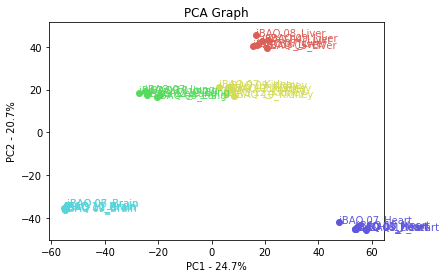

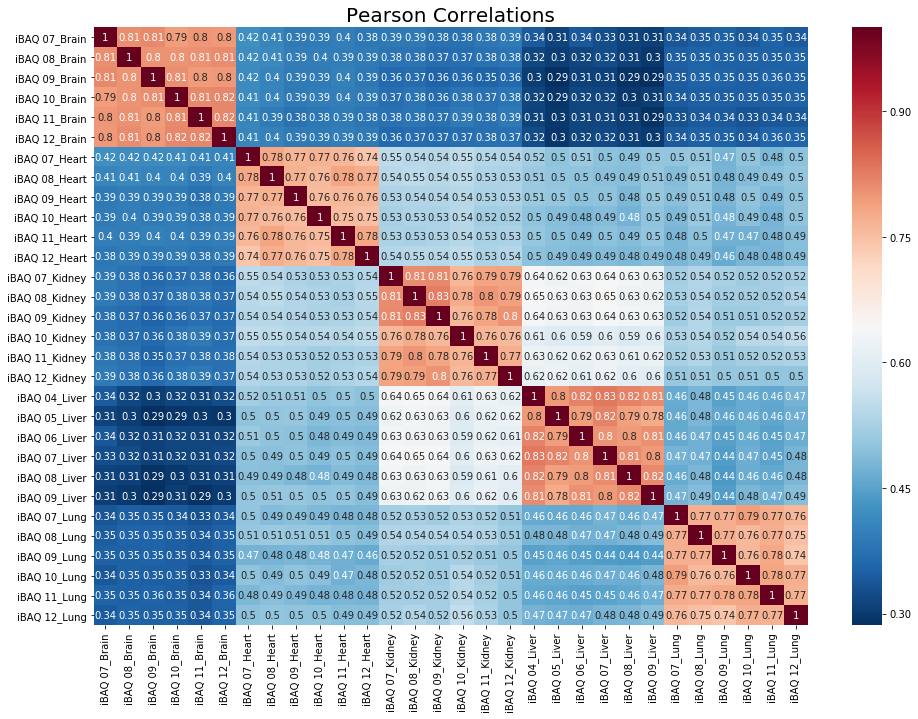

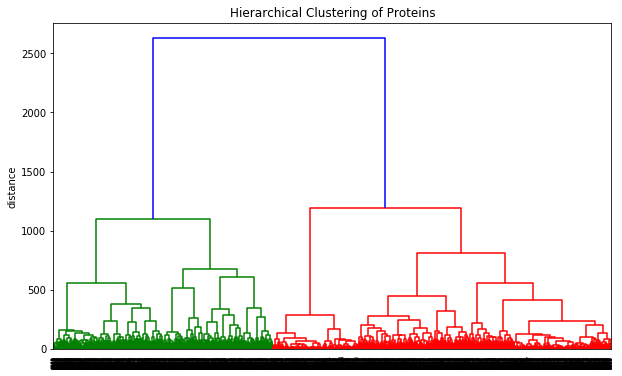

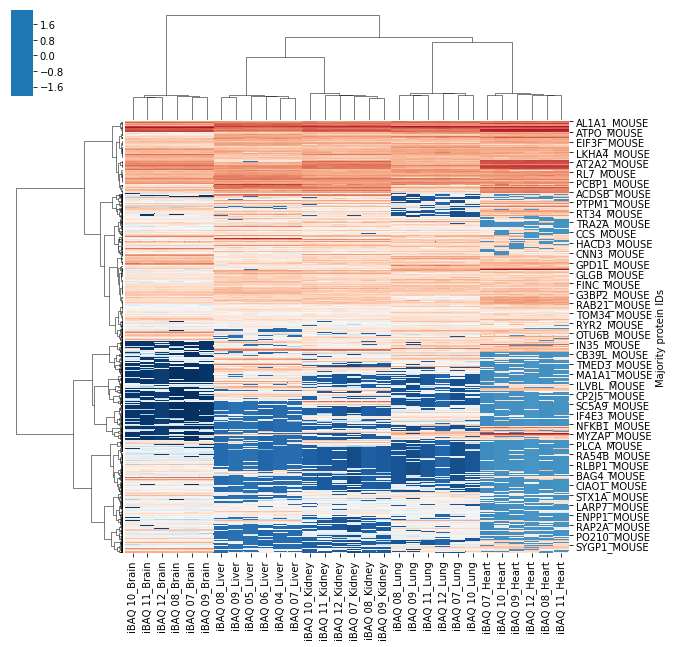

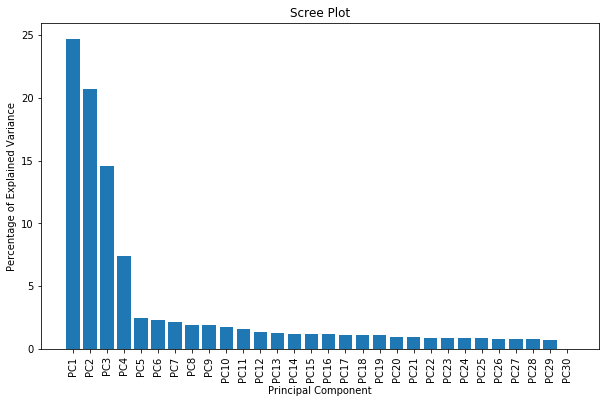

In [504]:
datafile = "D:\proteinGroupsCleaned.txt"
sample_groups = ['Brain', 'Heart', 'Kidney', 'Liver', 'Lung']
base_dir = 'D:\\Images\\PipelineTest\\'

mq_pipeline(datafile, sample_groups, base_dir)

## TODO 
* Dynamically determine column indices for organ groups, size of groups; order columns
* Take argument to choose iBAQ or LFQ? Or just do both
* Write images out to file - take arguments for base directory and specific dataset name
* Pipeline combining all functions